## Importing required libraries

In [1]:
import sys 
sys.path.append('/home/aistudio/external-libraries')

import jax 
import jax.numpy as jnp
import optax
import jaxopt
from jax import device_put

jax.config.update("jax_enable_x64", True)

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = '/home/aistudio/Times_New_Roman.ttf'
prop = font_manager.FontProperties(fname=font_path)

## Data Loading and Generating

In [2]:
# Load the dataset containing solutions computed by MATLAB's DDE23 solver
# The data corresponds to a system of delayed differential equations (DDEs) with specific parameters
data_path = '/home/aistudio/work/NDDEs_for_the_system_of_DDEs/Fordward_Problem/ex_1_matlab_0.2_0.3_0.4_0.5.csv'
data = pd.read_csv(data_path)

# N_i represents the number of boundary conditions, conds represents the initial condition y_j(0) = 1, j=1:3
N_i = 1
t0 = jnp.ones([N_i, 1], dtype='float64') * 0.0
u0 = jnp.ones_like(t0)
conds = jnp.concatenate([t0, u0, u0, u0], axis=1)

# Initial key for random number generator
ik = 0

# Number of internal random points
N_f = 5000

# Range for sampling points
tmin, tmax = 0.0, 1.0

# Generate random points within the specified range
jaxKey = jax.random.PRNGKey(ik)
inPoints = jax.random.uniform(jaxKey, minval=tmin, maxval=tmax, shape=(N_f,1), dtype='float64')

## DNNs Model Definition and Parameter Initialization

In [3]:
# Define the DNNs model
def DNNs(params, x):
    for w, b in params[:-1]:
        x = jnp.dot(x, w) + b
        x = jnp.tanh(x)
        
    w, b = params[-1]
    x = jnp.dot(x, w) + b
    return x

# Xavier initialization for the layer parameters
def random_layer_params_xavier(m, n, key):
    # Define lower and upper bounds for Xavier initialization
    lb, ub = -(1/jnp.sqrt(m)), (1/jnp.sqrt(n)) 

    w_key, b_key = jax.random.split(key)
    return lb + (ub-lb) * jax.random.uniform(w_key, (m, n)), jax.random.uniform(b_key, (n,))

# Initialize parameters for all layers in a fully-connected neural network with the specified sizes
def init_network_params(sizes, key):
    keys = jax.random.split(key, len(sizes))
    return [random_layer_params_xavier(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

## Defining the System of Delay Differential Equation

Consider the system of delay differential equations with quadruple delays on the solution interval $[0,1]$:

\begin{equation}
    \begin{cases}
    \begin{aligned}
    y_1'(t) ={} & y_1(t-0.2)\\
    y_2'(t) ={} & y_1(t-0.3) \cdot y_2(t-0.4)\\
    y_3'(t) ={} & y_2(t-0.5)
    \end{aligned}
    \end{cases}.
\end{equation}


The initial conditions are given by

\begin{equation}
    y_j(t) = 1,~\mathrm{for}\; t \in [-1, 0],\; j=1:3.
\end{equation}

In [4]:
def DDEs(t, u, lag):
    rhs = [
        jnp.where(t > lag[0], u(t - lag[0])[0], 1),
        jnp.where(t > lag[1], u(t - lag[1])[0], 1) + jnp.where(t > lag[2], u(t - lag[2])[1], 1),
        jnp.where(t > lag[3], u(t - lag[3])[1], 1)
    ]

    tem_list = []

    for i in range(3):
        u_t = lambda t: jax.grad(lambda t: jnp.sum(u(t)[i]))(t)
        tem_i = u_t(t) - rhs[i]
        tem_list.append(tem_i.reshape(-1, 1))

    tem = jnp.hstack(tem_list)
    
    return tem

## Defining the loss function

In [5]:
@jax.jit
def loss_fun(params, inPoints, conds, lag):
    t_c = inPoints[:,[0]]

    ufunc1 = lambda t: DNNs(params[0], t)
    ufunc2 = lambda t: DNNs(params[1], t)
    ufunc3 = lambda t: DNNs(params[2], t)

    def u(t):
        return [ufunc1(t), ufunc2(t), ufunc3(t)]

    # Calculate the loss due to the differential equation
    loss_f1 = jnp.mean((DDEs(t_c, u, lag)[:,0])**2)
    loss_f2 = jnp.mean((DDEs(t_c, u, lag)[:,1])**2)
    loss_f3 = jnp.mean((DDEs(t_c, u, lag)[:,2])**2)

    # Calculate the loss due to the initial conditions
    t_0, u1_0, u2_0, u3_0= conds[:,[0]], conds[:,[1]], conds[:,[2]], conds[:,[3]]
    loss_i1 = jnp.mean((ufunc1(t_0)-u1_0)**2)
    loss_i2 = jnp.mean((ufunc2(t_0)-u2_0)**2)
    loss_i3 = jnp.mean((ufunc3(t_0)-u3_0)**2)

    # Compute the sum loss from all components
    loss_sum = loss_f1 + loss_f2 + loss_f3 + loss_i1 + loss_i2 + loss_i3

    # Calculate the weighted contribution of each loss component to the total loss
    w_f1 = loss_f1/loss_sum
    w_f2 = loss_f2/loss_sum
    w_f3 = loss_f3/loss_sum

    w_i1 = loss_i1/loss_sum
    w_i2 = loss_i2/loss_sum
    w_i3 = loss_i3/loss_sum

    # Compute the weighted average of the losses to form the total loss
    loss_total = (
        w_f1 * loss_f1 + w_f2 * loss_f2 + w_f3 * loss_f3 +
        w_i1 * loss_i1 + w_i2 * loss_i2 + w_i3 * loss_i3
    )

    return loss_total

## DNNs initialization

In [6]:
# Define the network architecture with layer sizes
netLayers = [1, 20, 40, 20, 1]

# Initialize network parameters using a specified random key
# 'ik' should be predefined integer representing the random seed
key1 = jax.random.PRNGKey(ik)
params = [init_network_params(netLayers, key1)] * 3

# Define an array of lag values for the differential equations
lags = jnp.array([0.2, 0.3, 0.4, 0.5], dtype=jnp.float64)

In [8]:
# Initialize the list to store loss history
loss_history = []

# Define the number of training epochs
epochs = 80001

# Define the ADAM optimizer with exponential decay learning rate scheduler
scheduler = optax.exponential_decay(init_value=1e-3, transition_steps=10000, decay_rate=0.9)
optimizer = optax.adam(learning_rate=scheduler)

# Initialize the optimizer state
opt_state = optimizer.init(params)

# Define the update step, decorated with 'jax.jit' for performance optimization
@jax.jit
def update(params, opt_state, inPoints, conds, lags):
    # Compute loss and gradients
    loss, grads = jax.value_and_grad(loss_fun)(params, inPoints, conds, lags)
    # Update parameters based on gradients
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# Training loop
for epoch in range(epochs):
    # Update parameters and optimizer state, and record loss
    params, opt_state, loss = update(params, opt_state, inPoints, conds, lags)
    loss_history.append(loss)
    # Log loss every 2000 epochs
    if epoch % 2000 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Epoch 0, Loss: 87.90055414585473
Epoch 2000, Loss: 0.001963640170334557
Epoch 4000, Loss: 0.0004465867649068429
Epoch 6000, Loss: 0.0003610000497859725
Epoch 8000, Loss: 0.00024966863563859903
Epoch 10000, Loss: 0.00020286166671990442
Epoch 12000, Loss: 0.00014065078560532196
Epoch 14000, Loss: 0.00012291851445887545
Epoch 16000, Loss: 0.00011186884175183709
Epoch 18000, Loss: 0.00010649724956123022
Epoch 20000, Loss: 8.901620209449972e-05
Epoch 22000, Loss: 5.573613385968666e-05
Epoch 24000, Loss: 3.761564713299521e-05
Epoch 26000, Loss: 3.754860557153889e-05
Epoch 28000, Loss: 3.576777071748813e-05
Epoch 30000, Loss: 3.229732888662395e-05
Epoch 32000, Loss: 3.461401534126234e-05
Epoch 34000, Loss: 3.3673165083858646e-05
Epoch 36000, Loss: 3.0768885218506076e-05
Epoch 38000, Loss: 2.854922793855226e-05
Epoch 40000, Loss: 2.527586027913541e-05
Epoch 42000, Loss: 2.6010700269001318e-05
Epoch 44000, Loss: 2.516972303532335e-05
Epoch 46000, Loss: 1.939207840745736e-05
Epoch 48000, Loss: 1

## Result visualization

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


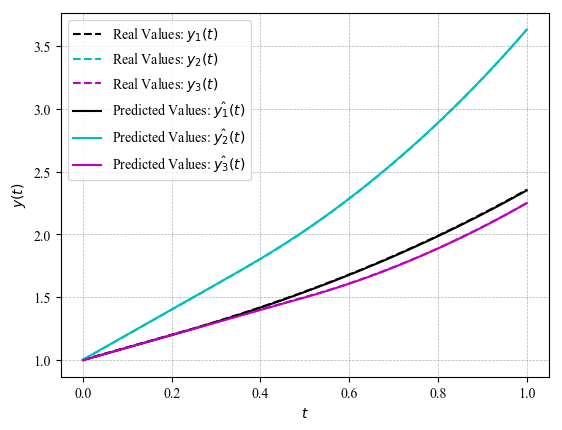

In [9]:
# Generate a set of 10,000 evenly spaced time points between tmin and tmax
T = np.linspace(tmin, tmax, 10000).reshape(-1,1)

# Evaluate the neural network for three sets of parameters to get predictions for each set
nn_sol1 = DNNs(params[0], T)
nn_sol2 = DNNs(params[1], T)
nn_sol3 = DNNs(params[2], T)

# Extract time points and real values from the data for three different series
t_points = data.iloc[:, 0]
y1_real = data.iloc[:, 1]
y2_real = data.iloc[:, 2]
y3_real = data.iloc[:, 3]

# Set the figure size to 16 cm wide by 12 cm tall (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Plot real and predicted values for three series using different styles and colors
plt.plot(t_points, y1_real, '--k', label='Real Values: $y_1(t)$')
plt.plot(t_points, y2_real, '--c', label='Real Values: $y_2(t)$')
plt.plot(t_points, y3_real, '--m', label='Real Values: $y_3(t)$')

plt.plot(T, nn_sol1, 'k', label='Predicted Values: $\hat{y_1}(t)$')
plt.plot(T, nn_sol2, 'c', label='Predicted Values: $\hat{y_2}(t)$')
plt.plot(T, nn_sol3, 'm', label='Predicted Values: $\hat{y_3}(t)$')

# Add a legend with font properties
plt.legend(prop=prop)

# Set labels for the x and y axes with font properties
plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$y(t)$', fontproperties=prop)

# Customize the appearance of the axis tick labels using font properties
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Enable grid lines for major axes with specified style and line width
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Optionally save the figure with high resolution
# Uncomment the next line to save the figure
# plt.savefig('DDEs_FP_ex1.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

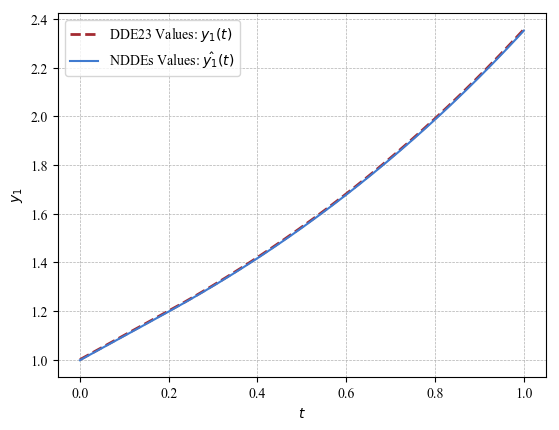

In [11]:
# Set the figure size to 16 cm wide by 12 cm tall (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Define a list of colors for different plots
colorList = ['#A32A31', '#407BD0']

# Plot real values obtained from MATLAB's DDE23 solver
plt.plot(t_points, y1_real, '--', label='DDE23 Values: $y_1(t)$', color=colorList[0], linewidth=2)
# Plot predicted values from the neural delay differential equation solver (NDDEs)
plt.plot(T, nn_sol1, label='NDDEs Values: $\hat{y_1}(t)$', color=colorList[1])

# Set labels for the x and y axes with custom font properties
plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$y_1$', fontproperties=prop)

# Enable grid lines for major axes with specified style and line width
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Add a legend with custom font properties
plt.legend(prop=prop)

# Get the current axes to adjust tick labels
ax = plt.gca()
# Customize the appearance of the axis tick labels using font properties
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Optionally save the figure with high resolution
# Uncomment the next line to save the figure
# plt.savefig('DDEs_FP_ex1_1.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

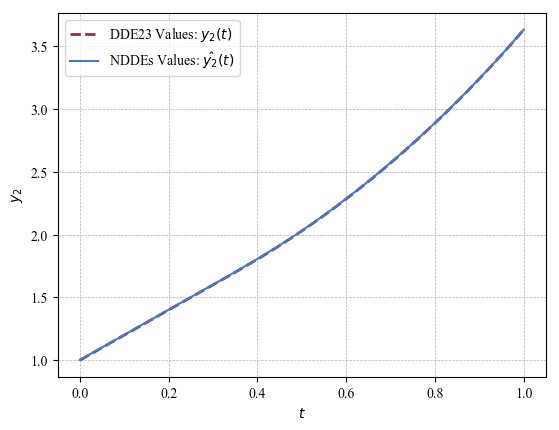

In [13]:
# Set the figure size to 16 cm wide by 12 cm tall (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Define a list of colors for different plots
colorList = ['#A32A31', '#407BD0']

# Plot real values obtained from MATLAB's DDE23 solver
plt.plot(t_points, y2_real, '--', label='DDE23 Values: $y_2(t)$', color=colorList[0], linewidth=2)
# Plot predicted values from the neural delay differential equation solver (NDDEs)
plt.plot(T, nn_sol2, label='NDDEs Values: $\hat{y_2}(t)$', color=colorList[1])

# Set labels for the x and y axes with custom font properties
plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$y_2$', fontproperties=prop)

# Enable grid lines for major axes with specified style and line width
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Add a legend with custom font properties
plt.legend(prop=prop)

# Get the current axes to adjust tick labels
ax = plt.gca()
# Customize the appearance of the axis tick labels using font properties
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Optionally save the figure with high resolution
# Uncomment the next line to save the figure
# plt.savefig('DDEs_FP_ex1_1.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

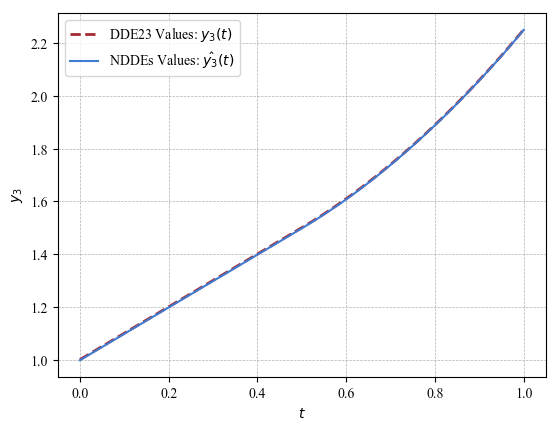

In [14]:
# Set the figure size to 16 cm wide by 12 cm tall (4:3 aspect ratio)
plt.figure(figsize=(16 / 2.54, 12 / 2.54))

# Define a list of colors for different plots
colorList = ['#A32A31', '#407BD0']

# Plot real values obtained from MATLAB's DDE23 solver
plt.plot(t_points, y3_real, '--', label='DDE23 Values: $y_3(t)$', color=colorList[0], linewidth=2)
# Plot predicted values from the neural delay differential equation solver (NDDEs)
plt.plot(T, nn_sol3, label='NDDEs Values: $\hat{y_3}(t)$', color=colorList[1])

# Set labels for the x and y axes with custom font properties
plt.xlabel('$t$', fontproperties=prop)
plt.ylabel('$y_3$', fontproperties=prop)

# Enable grid lines for major axes with specified style and line width
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)

# Add a legend with custom font properties
plt.legend(prop=prop)

# Get the current axes to adjust tick labels
ax = plt.gca()
# Customize the appearance of the axis tick labels using font properties
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(prop)

# Optionally save the figure with high resolution
# Uncomment the next line to save the figure
# plt.savefig('DDEs_FP_ex1_1.png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

## Calculating L2 relative error

In [10]:
def l2_error(i, points, y_real):
    global params_gpu
    y_pred = DNNs(params[i],jnp.array(points).reshape(-1,1))
    y_pred = jax.device_get(y_pred).reshape(1,-1)
    y_real = y_real.to_numpy()
    q = np.linalg.norm(y_real, ord=2)
    p = np.linalg.norm(y_real-y_pred, ord=2)
    print("the L2 error is :", p/q)


l2_error(0, t_points, y1_real)
l2_error(1, t_points, y2_real)
l2_error(2, t_points, y3_real)

the L2 error is : 0.002089671708872976
the L2 error is : 0.0009629956160897756
the L2 error is : 0.0013227536907182292
